# Aplicação 01: Detecção de símbolos em um canal AWGN com Deep Neural Network (DNN)

Neste experimento, serão introduzidos os conceitos iniciais de Deep Neural Network (DNN), abordando-se o problema da detecção de símbolos em um canal AWGN.







## Identificação:

**Nome:**

**Matrícula:**

## 1. Objetivo

O objetivo deste experimento é introduzir as redes Deep Neural Network (DNN), que é a base para todas as outras redes que virão, mostrando uma aplicação prática e eficiente.

Nesta aplicação, será implementada uma DNN para realizar a detecção de símbolos enviados em um canal com ruído branco aditivo gaussiano *(Aditive White Gaussian Noise - AWGN)*, dado que modulação utilizada é a Modulação de Amplitude em Quadratura *(Quadrature Amplitude Modulation - QAM)*, optando-se pelo 16-QAM, em que cada um dos 16 símbolos que são enviados pelo canal correspondente a uma palavra binária de 4 bits. 

Ao final, os resultados obtidos utilizando-se a DNN serão comparados com o desempenho do detector ótimo, com a finalidade de se verificar a acurácia da DNN treinada.



## 2. Preparação do Ambiente

Todas as informações necessárias para resolver esta aplicação estão neste ambiente e todas as partes do código devem ser implementadas ao longo deste notebook.

Antes de iniciarmos, precisa-se que algumas bibliotecas já estejam disponíveis. São elas:

- Numpy: (http://www.numpy.org/) para todas as operações matriciais;
- Matplotlib: (https://matplotlib.org/) para a plotagem dos gráficos;
- Scipy: (https://docs.scipy.org/doc/scipy/reference/) que contém funções e ferramentas de cálculo numérico e científico;
- Pytorch: (https://pytorch.org/docs/stable/index.html) que disponibiliza diversas funções que simplificam a criação de um modelo de inteligência artificial, acelerando a elaboração dos códigos.

Para configurar o ambiente, será necessário permitir o acesso ao seu Google Drive, de onde serão importados os datasets, além de outros módulos adicionais.


A célula abaixo irá "montar" o drive dentro do Google Colaboratory, ou seja, conseguiremos acessar diretamente todos os conteúdos presentes no Google drive, possibilitando a execução do *Jupyter Notebook* a partir, unicamente, da nuvem.

In [13]:
#allows the drive to be accessed 
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [14]:
import sys

!cat '/content/drive/MyDrive/Minicurso/Experimento 1/utils.py'
sys.path.append('/content/drive/MyDrive/Minicurso/Experimento 1')

import numpy as np
import math
import cmath
import csv
import time
import matplotlib.pyplot as plt
import os
from scipy.signal import hilbert
from scipy.spatial import distance
from scipy.special import erfc


def testar_gpu():
    train_on_gpu = torch.cuda.is_available() #Observa se a GPU está disponivel
    if train_on_gpu: #Se sim
        device = torch.device('cuda') #Seleciona o device como GPU
        print("Treinando na GPU") #E manda a mensagem
    else: #Se não
        device = torch.device('cpu') #Seleciona o device como cpu
        print("GPU indisponível, treinando na CPU") #E avisa que a GPU não esta disponível
    return device


def create_csv_rect(modelo, dict_SNRs):
    SNRs, num_exemplos = list(dict_SNRs.keys()), list(dict_SNRs.values())
    for i in range(len(SNRs)):
        arquivo = str(modelo.M) + '_QAM_rect' + str(SNRs[i]).replace('.',',') + '.csv' 
        with open(arquivo, 'w', newline='') as myfile:
            wr = csv.writer(myfile, delimiter=',', quoting=c

Com o acesso permitido ao drive e com o ambiente preparado, podemos iniciar a importação das bibliotecas de Python que serão utilizadas no nosso código. 


In [15]:
import math

import numpy as np

import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.special import erfc, erfcinv
from scipy.integrate import quad
import turtle
import itertools
import torch

from abc import ABC, abstractmethod


Antes de iniciarmos a implemetação do código de fato, vamos verificar se há alguma GPU disponível para rodar os códigos, com o intuido de tornar mais rápido o treinamento da DNN.

In [16]:
train_on_gpu = torch.cuda.is_available() #Check if the GPU is available
if train_on_gpu: #if yes
    device = torch.device('cuda') #Select device as GPU
    print("Treinando na GPU.")
else: #If not
    device = torch.device('cpu') #Select device as CPU
    print("GPU indisponível, treinando na CPU.")

Treinando na GPU.


## 3. Introdução Teórica

### 3.1 *Quadrature Amplitude Modulation* (QAM)



Na modulação de amplitude em quadratura (QAM), dois sinais cossenoidais defasados de 90 graus (por exemplo, um seno e o outro cosseno) são multiplicados por dois sinais de informação $I(t)$ e $Q(t)$ e, em seguida, combinados. Dada a diferença de fase de 90°, os sinais cossenoidais são ditos em quadratura, e isso dá origem ao nome da técnica de modulação. A expressão abaixo mostra essa composição matematicamente: $$S(t) = I(t)\cos(2\pi f_ct) - Q(t)\sin(2\pi f_ct)$$

O sinal modulado $S(t)$ contém variações de amplitude e fase, e, então, cada símbolo gerado possui uma combinação de amplitude e fase específica, que o diferecia dos demais símbolos. Os símbolos gerados e que serão enviados pelo canal podem ser mapeados em um diagrama de estado. Este diagrama é realizado a partir das funções de base do sistema M-QAM. 

Com essa representação, um símbolo pode ser representado por suas duas coordenadas no diagrama de estado, também conhecido como constelação do sistema, e é a partir dessas coordenadas que o símbolo é decodificado.

Na imagem abaixo, por exemplo, onde é representado um sistema 8-QAM, o símbolo $S_m$ pode ser descrito por sua coordenada no eixo horizontal, base $Ѱ_1$, e por sua coordenada no eixo vertical, base $Ѱ_2$. Logo, pode-se representar o símbolo $S_m$ como o par de coordenadas $(S_{m1};S_{m2})$, onde $S_{m1}$ é a projeção do símbolo $S_m$ na base $Ѱ_1$ e $S_{m2}$ é a projeção do símbolo $S_m$ na base $Ѱ_2$.


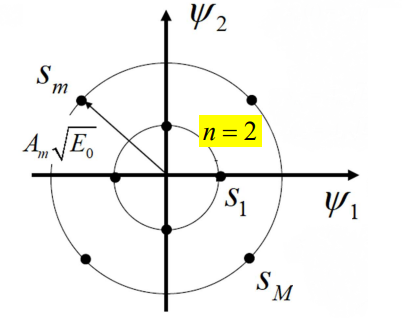

Na modulação M-QAM, o termo *M* refere-se a quantidade de símbolos que a comunicação terá. O exemplo acima aborda o caso em que $M = 8$, porém, em aplicações reais, utilizam-se valores de $M = 2^l$, onde $l$ é o número de bits por símbolo que a comunicação terá. No sistema de comunicação móvel 5G, por exemplo, a modulação poderá chegar até 256-QAM. No sistema WiFi 6 (IEEE 802.11ax), pode-se chegar a 1024-QAM.


### 3.2 Canal *AWGN*

Em um canal AWGN, o sinal transmitido é contaminado pelo ruído, o que causa distorção, de forma que o sinal recebido não será igual ao sinal transmitido. O sinal distorcido é dado pela soma do sinal transmitido com o ruído, em que o valor do ruído, em cada instante, pode ser modelado por meio de uma variável aleatória que respeita a distribuição gaussiana, com média nula e variância $\sigma^2$.

Portanto, a presença do ruído AWGN no canal resulta na distorção aleatória do sinal recebido pelo receptor, de modo que a aleatoriedade presente no processo pode confundir o detector, causando erro na decodificação. Quanto maior for esta distorção, ou seja, quanto maior for a potência do ruído em relação a potência do sinal original, maior será a probabilidade de se tomar a decisão pelo símbolo errado. 

Uma forma de se mensurar a distorção que será causada pelo ruído é medir a Razão entre a potência do Sinal ($Psignal$) e a potência do Ruído ($Pnoise$) $(Signal-to-Noise - SNR)$. A expressão apresentada abaixo equaciona essa relação.



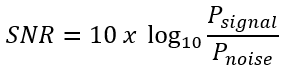

A distorção do sinal transmitido também implica distorção na sua representação no diagrama de estado, já que, considerando o canal AWGN, essa distorção é dada pela soma do sinal original com um vetor $n$ com coordenadas $(n_1, n_2)$, ambas sendo variáveis aleatórias gaussianas, com média nula e variância $\sigma^2$. O resultado é que o ponto que representa o símbolo $m$ é deslocado para as coordenadas $(S_{m1} + n_1;S_{m2} + n_2)$. Assim, é possível determinar que o sinal recebido $r$ será dado por: $$r = s + n$$

em que $s$ é o sinal enviado e $n$ é o ruído do canal, ambos representados como vetores no diagrama de estado do sinal modulado.

Do ponto de vista físico, quanto maior for a potência do ruído presente no canal de comunicação, maior será o valor da variância que representa esse ruído. Com isso, quanto maior for a potência do ruído em relação à potência do sinal, mais difícil será para o receptor detectar de forma correta o símbolo enviado, pois o sinal recebido estará tão contaminado com o ruído que, em alguns momentos, os símbolos não serão facilmente distinguíveis. Em outras palavras, quanto menor a SNR, maior é a probabilidade de o detector realizar a escolha pelo símbolo incorreto.

Com o intuito de visualizar o comportamento mencionado acima, implementou-se uma classe que modela a modulação M-QAM em um canal AWGN. Na célula abaixo, é instanciada essa classe e, logo após, é chamado o método "constelacao_completa()" que permite visualizar a constelação do sistema M-QAM dadas as configurações escolhidas.

Foi definido que serão tomadas, no receptor, 5 amostras por símbolo. Com isso, varie a SNR e visualize o comportamento do processo de amostragem. Além disso, varie de 16-QAM para 64-QAM, e também 256-QAM. Note que a distância entre cada símbolo diminui à medida em que a modulação possui mais símbolos e se mantém a SNR. Varie, igualmente, a quantidade de amostras por símbolo e veja uma núvem de pontos ser formada em torno do vetor que corresponde ao símbolo enviado.

No que será visualizado, a estrela em vermelho refere-se ao símbolo enviado e os pontos pretos referem-se as amostras tomadas no receptor.

In [17]:
# SNR do canal
SNR = 10
# Instanciando a classe M_QAM
# Parametros: M-QAM, Ruido, SNR, Número de amostragem
m_QAM = utils.M_QAM(16,True,SNR,5)
m_QAM.constelacao_completa()

NameError: ignored

Após a transmissão do sinal pelo canal de comunicação e com sua chegada ao receptor, é preciso detectar os símbolos transmitidos. Nesta aplicação, usaremos um método diferente do convencional, na qual iremos treinar uma DNN para aprender os padrões de chegada de cada símbolo do sistema.

Um método convencional para a detecção de símbolos transmitidos de forma equiprovável por meio de um canal AWGN é o detector de máxima verossimilhança, o qual iremos utilizar para comparar os resultados obtidos ao final. Esse detector, também conhecido como detector ótimo, é formado por três elementos: um filtro casado, responsável por maximizar a relação sinal ruído do sinal (SNR); um amostrador; e um tomador de decisões.

Podemos interpretar o tomador de decisões no espaço de sinais como um medidor de distâncias entre o vetor que representa uma amostra do sinal distorcido recebido e os vetores que representam os M símbolos enviados no sistema. Em suma, devido a equiprobabilidade entre os símbolos, o tomador de decisões fará a escolha pelo símbolo mais próximo ao ponto que representa o símbolo recebido amostrado. 

A imagem abaixo ilustra este funcionamento, onde foi amostrado o ponto $P$ no receptor e o detector ótimo fará a escolha pelo símbolo que estiver mais próximo a este ponto amostrado, que no exemplo será o símbolo $S$.


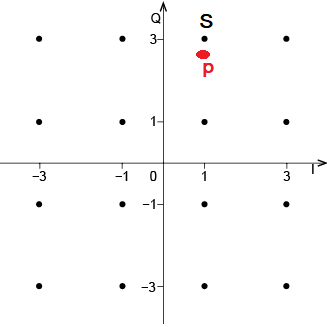

Ao aumentarmos a quantidade símbolos, a decisão de se escolher o símbolo correto se torna mais difícil. Isso acontece pois, para uma mesma energia média de símbolo (ou potência do sinal), ocorre uma diminuição na distância entre símbolos, conforme foi visto neste experimento ao variarmos o valor de M do sistema, passando-se de 16-QAM para os sistemas 64-QAM e 256-QAM.

Com essa diminuição da distância, um sinal amostrado pode mais facilmente se aproximar de um outro ponto que representa um símbolo incompatível com o símbolo enviado, resultando em uma detecção errada.


## 3.3 Redes Neurais

Após introduzirmos o que a aplicação tratará, vamos, de fato, começar a implementar a DNN. 

Iremos definir, de forma breve, os principais conceitos de uma rede neural. Porém, recomenda-se fortemente que o aluno se inscreva nesse [curso gratuito](https://www.coursera.org/learn/machine-learning/home/welcome) e assista às aulas das semanas 4 e 5, em que são abordados os aspectos matemáticos básicos de uma rede neural.

DNN é um tipo de rede neural que se insere no contexto de machine learning, área que busca ensinar computadores a realizarem tarefas complexas, como reconhecimento de fala, identificação de imagem e previsões de cenários futuros. Para a nossa aplicação, treinaremos uma rede para decidir, a partir de amostras tomadas no receptor, qual símbolo foi enviado.

O dataset será composto por 30 mil símbolos enviados em um canal AWGN. Cada símbolo será amostrado $Na$ = 5 vezes no receptor, ou seja, teremos as coordenadas no diagrama de estado do símbolo enviado  e, para cada símbolo, teremos 5 pares de coordenadas vetoriais, um para cada amostra tomada no receptor. Recomenda-se que o aluno varie o valor de $Na$ de forma a investigar a influência desse parâmetro no desempenho da DNN (veja com os tutores como proceder nesse caso).

Com o propósito de obter melhores resultados, misturamos no dataset símbolos que foram transmistidos em canais com diferentes SNRs. A divisão do dataset foi realizada da seguinte maneira:

  *   10% com SNR = 0  dB
  *   15% com SNR = 5  dB
  *   20% com SNR = 10 dB
  *   35% com SNR = 15 dB
  *   20% com SNR = 20 dB

Essa distribuição também pode ser variada pelo aluno, em busca de um melhor desempenho (veja com os tutores como proceder nesse caso). A célula abaixo realiza a leitura do arquivo csv com o dataset e guarda as amostras no array `data_amostras` e o símbolo enviado em `data_simbolos`.

In [18]:
m_QAM = utils.M_QAM(16,True,SNR,5)

data_simbolos, data_amostras = [],[]

with open('/content/drive/MyDrive/Minicurso/Experimento 1/Dataset/16_QAM_rectembaralhado_5_amostras.csv', 'r') as arquivo_csv:
  leitor = csv.reader(arquivo_csv, delimiter=',')
  for coluna in leitor:
      simbolo = eval(coluna[0])
      amostras = [(complex(i).real,complex(i).imag) for i in coluna[2:]]
      data_simbolos.append(simbolo)
      data_amostras.extend(amostras)

data_simbolos = np.asarray(data_simbolos)
data_amostras = np.asarray(data_amostras).reshape(-1,10)

NameError: ignored

In [ ]:
data_amostras

É mais conveniente, para a classificação, numerar cada símbolo do que tratá-los por meio de suas coordenadas. Por isso, a célula abaixo numera cada símbolo com os índices de 0 a 15 (O experimento definiu $M$ = 16, mas nada impede você treinar a sua rede para $M$ qualquer. Que tal experimentar diferentes $M$. Consulte os tutores no caso de necessitar de ajuda).

In [ ]:
# Numerando os símbolos
count = 0
for j in m_QAM.lista_par_ordenado:
    data_simbolos[np.where(np.all(data_simbolos == j, axis = 1))] = count
    count += 1
data_simbolos = data_simbolos[:,1]

A estrutura de uma rede neural busca ter o comportamento inspirado no de um cérebro humano, de modo a permitir que ela aprenda a executar determinadas tarefas, típicas aos humanos. Em busca desse comportamento, a rede tem sua formatação inspirada em nossos cérebros, onde sua composição é realizada por neurônios interconectados. Na rede neural, esses nerônios são conectados por ligações que possuem pesos, parâmetros ajustáveis e que são responsáveis por ponderar as informações recebidas a fim de encontrar uma configuração que permita que a rede execute a tarefa da maneira correta. Assim, o processo de aprendizagem da rede neural é um processo de ajuste desses parâmetros, buscando encontrar uma composição ideal para esses valores. 

Uma rede neural apresenta a seguinte estrutura: Uma camada de entrada (*input layer*), uma ou mais camadas ocultas (*hidden layers*) e uma camada de saída (*output layer*). 

A imagem abaixo demonstra o layout básico de uma rede neural.



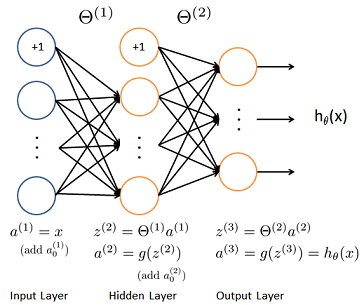

A interligação entre os neurônios da rede neural é realizada através das arestas. Para cada uma das arestas vista na imagem acima é atribuído um determinado peso, formando um conjunto de parâmetros $ \Theta$ em cada camada da rede neural.

Nós podemos entender que cada neurônio recebe uma parte dos sinais das variáveis de entrada e passa adiante uma versão ponderada e tratada desse sinal. Esses neurônios em paralelo formam uma camada oculta da rede neural, que faz uma nova ponderação no sinal recebido da camada de entrada. 

Na imagem, as matrizes $\Theta^{(1)}$ e $\Theta^{(2)}$ é onde estão armazenadas os pesos de cada uma das arestas que interligam a camada de entrada à camada oculta e a camada oculta à camada de saída, respectivamente.

Note que na camada oculta e na camada de saída é adicionado um valor constante igual a 1 a todos os neurônios. Este valor é denominado $bias$ (ou viés) e tem a funcionalidade de ajustar possíveis desvios existentes nos dados fornecidos, melhorando o desempenho da rede de modo a obter saídas mais acuradas.

## 3.3.1 FeedForward





*FeedForward* é o nome dado ao processo em que o sinal de entrada percorre a rede em uma única direção, da entrada para a saída.

No exemplo colocado na imagem acima, o processo do *feedfoward* está descrito na legenda. Note que a entrada é multiplicada pelos pesos que interligam a camada de entrada a camada oculta, que é dado por:

$$Z^{(2)} = \Theta^{(1)} \times X $$

em que $X$ são os valores da camada de entrada, ou *input*, em inglês. Para terminar o *feedforward*, temos, agora, que multiplicar o $Z^{(2)}$ pelo pesos que interligam a camada oculta a camada de saída, que é dado por:

$$Z^{(3)} = \Theta^{(2)} \times Z^{(2)} $$

As operações matemáticas que ocorrem em cada uma das etapas são multiplicações entre matrizes, pois, conforme dito, os pesos $\Theta^{(1)}$ e $\Theta^{(2)}$ são matrizes que armazenam os pesos de todas as arestas da rede, já que um neurônio se conecta com todos os outros neurônios das camadas vizinhas. Dessa forma, é importante perceber que a entrada e a saída também são vetores de comprimento ajustável.

Em resumo, o que acontece na *feedfoward* é a propagação dos valores de entrada através de multiplicações matriciais até chegarmos na saída da rede (nossa predição de qual símbolo foi enviado, por exemplo).


## 3.3.2 Funções de Ativação

Perceba que todas as operações apresentadas na última seção são lineares, o que limita o entendimento de tarefas que contenham características não lineares.

A partir disso, é comum utilizar funções de ativação não lineares após cada etapa do *feedforward*, justamente para dar à rede neural a possibilidade de compreender as não linearidades contidas no problema em questão.

Assim, aplicaremos uma função de ativação após cada etapa obtida no *feedforward*, o que pode ser equacionado como:

$$Z^{(2)} = \Theta^{(1)} \times X $$
$$a^{(2)} = g(Z^{(2)}) $$

E, posteriormente,

$$Z^{(3)} = a^{(2)} \times \Theta^{(2)} $$
$$a^{(3)} = g(Z^{(3)}) $$

em que $g(.)$ é a função de ativação.

Com isso, a nossa saída terá a característica de não linearidade. A função de ativação que utilizaremos em nosso problema será a $ReLU$, cujo gráfico está exposto abaixo (Caso esteja curioso, e é o que todos esperam de você, pesquise sobre o emprego de outras funções de ativação e verifique se alguma outra pode ser empregada no exemplo tratado neste experimento. Caso tenha alguma dificuldade, procure os tutores).



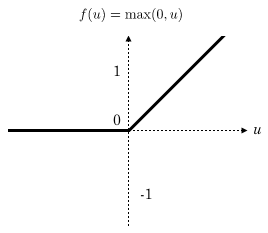

## 3.3.3 BackPropagation

Nesta etapa, busca-se otimizar os pesos com o intuito de mapear de uma melhor forma as entradas para a saída. A maneira que redes neurais realizam essa otimização é denominado *backpropagation*, já que a atualização dos pesos é feita das últimas camadas para as primeiras.

Antes, porém, precisa-se definir o que é uma função de custo. Uma rede neural funciona fazendo ajustes em seus parâmetros internos, os pesos, e esses ajustes são realizados com base na diferença entre os valores produzidos pela saída da rede e os valores esperados. A função de custo, $J(\Theta)$, é uma medida para mensurar o quão perto nossa rede está de gerar os valores esperados.

Note que a função de custo depende dos pesos da rede. Portanto, o objetivo na *backpropagation* é encontrar um conjunto de pesos $\Theta^{(1)}$ e $\Theta^{(2)}$ que minimiza o custo $J(\theta)$, com o objetivo de tornar a saída da rede o mais próximo possível do resultado real.

Existe uma variedade de opções de função de custo, e a escolha de qual utilizar irá depender do problema que está sendo tratado. No nosso caso, a função de custo será detalhada mais a frente, mas, de antemão, nosso problema é de classificação, portanto, deve-se optar por uma função de custo que trate essa perspectiva.

Para realizar a otimização dos parâmetros, utilizam-se algoritmos de otimização. Neste exemplo, trataremos do algoritmo **descida do gradiente**, mas existem outros. Neste algoritmo, busca-se determinar o quanto cada nó é "responsável" por qualquer erro na saída. O algoritmo segue as seguintes etapas:



1.   Escolher, de forma aleatória, um valor inicial para todos os pesos da rede;
2.   Para os pesos determinados, realizar a *feedfoward* e obter a saída da rede; 
3.   Calcular a função de custo (erro) da rede em relação ao valor esperado;
4.   Calcular o gradiente da função custo em relação a cada um dos pesos.
5.   Alterar os pesos na posição oposta ao do vetor gradiente, já que queremos **minimizar** a função de custo.

Realizamos a alteração do peso em busca do mínimo global da função de custo, pois é neste ponto que acontecerá o menor erro. O GIF abaixo demonstra este comportamento: no início, a função de custo possui valores altos e, de acordo com que aplicamos o gradiente descendente, a função descresce em direção ao seu mínimo global.

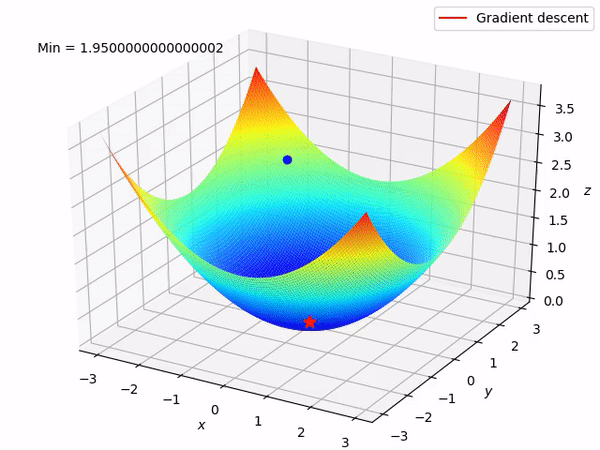

Como regra geral, os pesos são atualizados pela expressão abaixo: $$ \theta_{novo} = \theta_{antigo} - \alpha \frac{\partial J(\theta)}{\partial \theta}$$

Onde $\alpha$ é denominado **learning rate**(taxa de aprendizagem) e é utilizada para suavizar a convergência da função custo para o mínimo global. Caso seja escolhido um $\alpha$ grande, a função custo não irá convergir para o mínimo global, tendo resultados ruins. Caso $\alpha$ seja muito pequeno, a rede irá demorar muito para convergir. Portanto, deve-se escolher um $\alpha$ apropriado para cada rede e, geralmente, sua escolha é feita de forma empiríca.

## 4 DNN da Aplicação


Após introduzirmos os principais conceitos sobre redes neurais, vamos agora definir a rede neural que utilizaremos em nossa aplicação. Para a aplicação, utilizaremos um tipo de rede neural com mais de uma camada oculta, que recebe o nome de Deep Neural Network (DNN). Uma DNN utiliza os mesmos conceitos abordados acima, diferenciando-se pela quantidade de camadas ocultas.


### 4.1 Criação do Modelo

Relembre que serão coletadas $Na$ = 5 amostras de cada símbolos no receptor e, a partir dessas amostras, deverá ser detectado qual símbolo foi enviado. Como cada amostra pode ser lida pelo seu par de coordenadas no diagrama de estado do sistema, temos que a entrada da DNN deverá ser de $Na\times2=5\times2=10$ unidades (excluindo-se uma unidade extra de *bias* que sempre gera +1).

Além disso, a saída da rede deve ter $M$ = 16 unidades, em que cada uma representa um símbolo possível de serm enviado, já que estamos tratando do sistema 16-QAM. 

Nas camadas ocultas, ou *hidden layers*,  quanto mais unidades e quanto mais camadas tivermos, mais custo computacional teremos. Para nossa aplicação, determinou-se que duas camadas ocultas com 512 unidadess e 256 unidades, respectivamente, são suficiente para obter resultados bastante acurados (Mais uma vez deve estar batendo a curiosidade de alterar esses valores. Pois, então, experimente criar a sua própria rede e, no caso de alguma dúvida, consulte os tutores).. 

Construiremos agora essa rede utilizando o Pytorch. A estrutura dela é:

- Uma camada de entrada com função de ativação ReLU com:

        -> Input: 10     
        -> Output: 512
        -> Bias: True 
    
- Primeira camada oculta com função de ativação ReLU com: 

        -> Input: 512 
        -> Output: 256 
        -> Bias: True

- Segunda camada oculta com função de ativação ReLU com: 

        -> Input: 256 
        -> Output: 16 
        -> Bias: True        
    
- E a camada de saída que contém as saídas com as 16 classes esperadas (uma para cada símbolo possível de ser transmitido).


Sendo assim, construiremos a nossa rede neural a partir da classe `NeuralNetwork`. Essa classe é inicializada definindo as funções `fc1`, `fc2` e `fc3` que executam transformações lineares nos dados em cada camada, sendo que a primeira ocorre na camada de entrada (com 10 entradas e 512 saídas), a segunda na primeira camada oculta (com 512 entradas e 256 saídas) e a terceira na segunda camada oculta (com 256 entradas e 16 saídas).

Na sequência definiremos a função `forward()`, responsável por receber a entrada e passá-la pelos neurônios para gerar uma saída, utilizando a função ReLU como as funções de ativação na saída das três camadas em questão. 


In [ ]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        # The super() builtin returns a proxy object (temporary object of the superclass) that allows us to access methods of the base class.      
        super().__init__()
        # Our layers
        self.fc1 = torch.nn.Linear(in_features=10, out_features=512, bias=True)
        self.fc2 = torch.nn.Linear(in_features=512, out_features=256, bias=True)
        self.fc3 = torch.nn.Linear(in_features=256, out_features=64, bias=True)
        self.fc4 = torch.nn.Linear(in_features=64, out_features=16, bias=True)


    def forward(self, out):
        # foward() will perform linear activation on each layer
        out = torch.relu(self.fc1(out))
        out = torch.relu(self.fc2(out))
        out = torch.relu(self.fc3(out))
        out = torch.relu(self.fc4(out))

        return out

### 4.2 Processamento e tratamento dos dados de entrada

Quando estamos construindo um modelo de *machine learning* precisamos estimar o quão adequado ele é, baseado em alguma métrica. Adicionalmente, este teste de qualidade deve ser executado em dados que não foram usados no treinamento do modelo, assim poderemos medir a capacidade de generalização do modelo, observando o comportamento do modelo ao receber dados que nunca foram vistos.

Por isso, devemos dividir nossos dados em três partes, todas com o um objetivo específico. São elas:

*   **Treinamento:** De forma resumida, é a porção dos dados que será utilizada para ajustar o modelo. Ou seja, são os dados que serão utilizados para treinar o modelo, adequando os valores dos pesos de cada aresta a partir da inserção desses dados.

*   **Validação:** É a porção dos dados usada para fornecer uma avaliação imparcial, já que esses dados não serão utilizados para adequação dos parâmetros, medindo a capacidade de generalização da rede. Esse conjunto serve para verificar a necessidade de realizar ajustes do processo de treinamento da rede. Utiliza-se a validação para verificar se o modelo treinado não está tendo *overfitting*.

*   **Teste:** É a porção dos dados usada para avaliar o modelo ao final de todo o treinamento, sem a intenção de ajustar mais nenhum ponto do modelo. Então, utilizamos os dados de teste quando queremos predizer novos resultados para o nosso modelo.

Mas o que é *overfitting*? Há dois cenários que são possíveis, mas não desejáveis, quando se treina uma rede: o *overfitting* e o *underfitting*.

O *overfitting* é um cenário onde o modelo tem um desempenho excelente nos dados de treinamento, mas não consegue repetir essa performance nos dados de validação. Podemos entender que, neste caso, o modelo aprendeu tão bem as relações existentes nos dados de treino, que acabou apenas decorando o que deveria ser feito nesses casos, de forma que, ao receber as informações ainda não vistas, o modelo não consegue generalizar e acaba tentando aplicar as mesmas regras decoradas que acabam não funcionando, afetando o seu desempenho.

*Underfitting* é um outro cenário onde o desempenho do modelo converge muito lentamente no próprio treinamento, de forma que o processo de aprendizagem termina e o modelo não consegue encontrar relações entre as variáveis.

A imagem abaixo mostra três comportamento, um onde acontece o overfitting, outro é o que buscamos quando treinamos a rede e o ultimo é o caso onde acontece o underfitting.

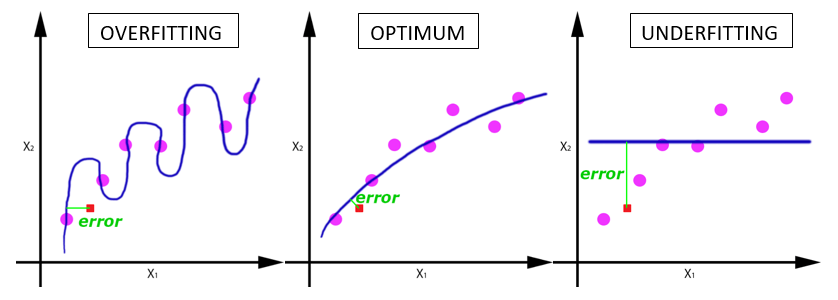

Com os motivos estabelecidos do porquê separar uma quantidade de dados para validação e teste, vamos, de fato, implementá-los. Conforme já dito, teremos 30 mil símbolos enviados em canais com diferentes SNR. Separaremos, de forma aleatória, 20% destes para validação do modelo. Para testar o modelo, separamos dados em outros dataset, que será apresentado mais a frente.



In [ ]:
#validation size
valid_size = 0.2

# obtain training indices that will be used for validation
num_train = data_simbolos.size
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

Uma vez criada a estrutura da rede neural, nós precisamos fazer o processamento dos dados de entrada, adequando-os para um formato em que a classe que criamos possa processá-los para fazer a aprendizagem dos parâmetros da rede.

Como os dados já foram importados, iremos transformá-los em tensores antes de criarmos o dataset. Para isso, nós utilizaremos os métodos `torch.Tensor()` e `torch.LongTensor()`. A diferença entre os dois é apenas a de que o primeiro aceita valores do tipo `float` (mais especificamente `float32`) enquanto o segundo aceita valores do tipo `int` (mais especificamente `int64`).

In [ ]:
# Data for validation and training
amostras_train, simbolos_train = data_amostras[train_idx],data_simbolos[train_idx]
amostras_valid, simbolos_valid = data_amostras[valid_idx],data_simbolos[valid_idx]

# Transform the inputs and labels into tensors
train_amostras, train_simbolos = torch.Tensor(amostras_train), torch.LongTensor(simbolos_train)
valid_amostras, valid_simbolos = torch.Tensor(amostras_valid), torch.LongTensor(simbolos_valid)

Feito isso, nós já podemos criar o nosso dataset que será utilizado no treinamento da rede neural. Para isso nós utilizaremos as funções `TensorDataset` e `DataLoader`.

Nessas funções, nós selecionaremos o tamanho desejado para o *batch*, além da opção de embaralhar (*shuffle*) os dados para melhorar a performance da rede neural. 

In [ ]:
# Batch Size
batch_size = 100

# Creating the dataset with the two tensors
dataset_train = TensorDataset(train_amostras, train_simbolos)
dataset_valid = TensorDataset(valid_amostras, valid_simbolos)

dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_valid = DataLoader(dataset_valid, batch_size=batch_size, shuffle=True)

### 4.3 Treinamento e Validação da DNN

Para o treinamento da rede neural é preciso escolher qual função de custo será utilizada e qual será o algoritmo de otimização dos parâmetros da rede.

O Pytorch disponibiliza vários tipos de função de custo dentro do módulo `torch.nn`. Entre os mais conhecidos estão a Entropia Cruzada (*Cross Entropy*) e o Erro Quadrático Médio (*Mean Squared Error*). A documentação de todas essas funções de erro que o Pytorch fornece estão disponíveis [neste link](https://pytorch.org/docs/stable/nn.html#loss-functions).

Quanto ao algoritmo de otimização, a biblioteca também disponibiliza diversos tipos, entre os mais conhecidos estão o *Gradient Descedent*, o *Stochastic Gradient Descedent* e o Adam. A documentação destes e de outros algoritmos de otimização estão disponíveis [neste link](https://pytorch.org/docs/stable/optim.html#algorithms).

No nosso programa, os escolhidos foram a *Cross Entropy* para função de custo e, como algoritmo de otimização, foi escolhido o *Stochastic Gradient Descedent* com valores iniciais de *learning rate* de 0,06 e *momentum* de 0,9.

Com tudo configurado, podemos instanciar a nossa rede neural na variável `model`.

In [ ]:
# Instantiate the NN into variable model
model = NeuralNetwork()

# Definition of cost function
criterion = torch.nn.CrossEntropyLoss()

# Definition of SGD as optimizer algorithm and its parameter sets
optimizer = torch.optim.SGD(model.parameters(), lr=0.006, momentum=0.9)

Uma vez que os dados de treino estão processados corretamente e o modelo está devidamente instanciado com função de custo e algoritmo de otimização configurados, devemos construir o loop de treinamento da rede.

Nós escolheremos, primeiramente, o número de épocas pelo qual a nossa rede neural passará nessa etapa de treinamento. Em cada uma dessas épocas, a rede neural deve criar outro loop em que cada exemplo do dataloader será explorado, calculando o erro e otimizando os parâmetros ao final de cada um desses exemplos.

A célula abaixo realiza o cálculo do custo em cada etapa do treinamento e, em seguida, realiza a otimização da rede, além de apresentar o valor da função custo em cada época e apresentar a acurácia para os dados de validação por época.

In [ ]:
# number of epochs to train the model
epochs = 30

train_losses, valid_losses, validation_acc = [], [], []
acc_old = 0

for e in range(epochs):
    
    correct,total = 0,0
    train_loss,valid_loss = 0,0
    
    ###################
    # train the model #
    ###################
    model.train()  # prep model for training
    for signal, labels in dataloader_train:
        
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(signal)
        # calculate the loss
        loss = criterion(output, labels)
        # backward pass: compute gradient of the loss with respect to model parameters)
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()

    
    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for signal, labels in dataloader_valid:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(signal)
        # calculate the loss
        loss = criterion(output, labels)
        # update running validation loss 
        valid_loss += loss.item()

        # idx max - Validation Accuracy
        _,predict = torch.max(output, dim = 1)
        for i in range(0,len(labels)):
            total = total + 1
            if predict[i] == labels[i]:
                correct = correct + 1

    else:
        train_loss = train_loss/len(dataloader_train)
        valid_loss = valid_loss/len(dataloader_valid)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        acc = (correct/total)*100
        validation_acc.append(acc)
        if acc > acc_old:
          # Salvando o modelo que apresenta a melhor acurácia para os dados da validação
          torch.save(model.state_dict(), 'model') 
          acc_old = acc        
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(
        e+1, 
        train_loss,
        valid_loss,
        acc
        ))

Após o treinamento, é esperado que tenhamos uma acurácia nos dados de validação por volta de 91%. O gráfico abaixo exibe a evolução da acurácia a cada época que a rede treina. 


In [ ]:
plt.figure(figsize=(15,8))
plt.plot(validation_acc,label='Validation Acuracy (%)')
plt.title('Validation Accuracy x Epochs')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.legend()
plt.show()

Com a rede treinada, podemos plotar os valores da função de custo em função do número de épocas, para que possamos analisar o comportamento dela e visualizarmos se houve a convergência esperada.

A célula abaixo plotará os dois gráficos (da função de perda do traino e da função de perda da validação).

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(train_losses,label='Training')
plt.plot(valid_losses, label='Validation')
plt.title('Cost x Epochs')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.grid(True)
plt.legend()
plt.show()

Note que não necessáriamente aumentar a quantidade de épocas de treinamento irá aumentar o desempenho da rede. 

A rede utilizada será aquela que apresentar maior acurácia nos dados da validação.

### 4.4 Teste da Rede Treinada

Conforme já mencionado, deve-se realizar testes na rede treinada com dados que não pertencem ao conjunto de treinamento. Por isso, separamos alguns datasets para que estes testes sejam realizados.

Para os testes, veremos a acurácia da rede para símbolos que foram enviados em canais que presenciam diferentes SNRs. Para avaliação de desempenho, usaremos a taxa de erro por símbolo (*Symbol Error Rate* - SER), variável que mensura qual é a probabilidade de um símbolo ser detectado erroneamente ao ser transmitido em um canal com uma determinada SNR. Veremos o resultado da técnica proposta comparada com a SER do detector ótimo, que, como o nome já sugere, é o melhor detector de símbolos em um canal AWGN.

A função abaixo extrai os dados de todos os datasets que iremos utilizar para os testes. Há 6 datasets disponíveis, cada um deles para um canal com SNR diferente.

São 6 datasets com 10 mil amostras cada. Isso é necessário, pois buscaremos traçar uma curva da probailidade de erro de detecção de um símbolo em função da SNR do canal.

Temos dados para um canal com os seguintes SNR: 0 dB, 2.5 dB, 5 dB, 7.5 dB, 10 dB, 12.5 dB e 14 dB.

In [ ]:
def read_csv(modelo,db):
    
  data_simbolos_teste, data_amostras_teste = [],[]

  with open('/content/drive/MyDrive/Minicurso/Experimento 1/Dataset/16_QAM_rect' + db + '_5_amostras.csv', 'r') as arquivo_csv:
    leitor = csv.reader(arquivo_csv, delimiter=',')
    for coluna in leitor:
        simbolo_teste = eval(coluna[0])
        amostras_teste = [(complex(i).real,complex(i).imag) for i in coluna[2:]]
        data_simbolos_teste.append(simbolo_teste)
        data_amostras_teste.extend(amostras_teste)

  data_simbolos_teste = np.asarray(data_simbolos_teste)
  data_amostras_teste = np.asarray(data_amostras_teste).reshape(-1,10)

  # Nomeando os simbolos
  count = 0
  for j in modelo.lista_par_ordenado:
    data_simbolos_teste[np.where(np.all(data_simbolos_teste == j, axis = 1))] = count
    count += 1
    
  data_simbolos_teste = data_simbolos_teste[:,1]

  return data_simbolos_teste, data_amostras_teste

Na célula abaixo, iremos realizar a leitura dos arquivos csv disponíveis na pasta do notebook.

In [ ]:
data_simbolos_0    , data_amostras_0    = read_csv(m_QAM,"0")
data_simbolos_2_5  , data_amostras_2_5  = read_csv(m_QAM,"2,5")
data_simbolos_5    , data_amostras_5    = read_csv(m_QAM,"5")
data_simbolos_7_5  , data_amostras_7_5  = read_csv(m_QAM,"7,5")
data_simbolos_10   , data_amostras_10   = read_csv(m_QAM,"10")
data_simbolos_12_5 , data_amostras_12_5 = read_csv(m_QAM,"12,5")
data_simbolos_14   , data_amostras_14   = read_csv(m_QAM,"14")

Com os dados ajustados, vamos, agora, obter a acurácia de nossa rede por meio da função abaixo, a qual nos retornará a acurácia para cada SNR.

In [ ]:
def calc_acuracia(db_canal, amostras, simbolos, size):

  # Transform the inputs and labels into tensors
  teste_amostras, teste_simbolos = torch.Tensor(amostras), torch.LongTensor(simbolos)
  # Batch Size
  batch_size = size

  # Creating the dataset with the two tensors
  dataset_teste = TensorDataset(teste_amostras, teste_simbolos)
  dataloader_teste = DataLoader(dataset_teste, batch_size=batch_size)

  # Instantiate the NN into variable model
  model_teste = NeuralNetwork()
  model_teste.load_state_dict(torch.load('model', map_location=torch.device('cpu')))
  
  correct_teste, total_teste = 0,0
  model_teste.eval() # prep model for evaluation
  for signal_teste, labels_teste in dataloader_teste:
    output_teste = model_teste(signal_teste)

  _,predict_teste = torch.max(output_teste, dim = 1)
  for i in range(len(labels_teste)):
    total_teste = total_teste + 1
    if predict_teste[i] == labels_teste[i]:
      correct_teste = correct_teste + 1

  acc_teste = (correct_teste/total_teste)
  print('Acurácia do teste para SNR igual a ' + str(db_canal) + ' dB: {:.4f}'.format(acc_teste*100))

  return acc_teste

Chamando a função acima, na qual passamos os datasets como parâmetro, teremos a acurácia que a rede possui para os canais com diferentes SNR.

In [ ]:
acc_IA = []
acc_IA.append(1-calc_acuracia(0,data_amostras_0,data_simbolos_0,10000))
acc_IA.append(1-calc_acuracia(2.5,data_amostras_2_5,data_simbolos_2_5,10000))
acc_IA.append(1-calc_acuracia(5,data_amostras_5,data_simbolos_5,10000))
acc_IA.append(1-calc_acuracia(7.5,data_amostras_7_5,data_simbolos_7_5,10000))
acc_IA.append(1-calc_acuracia(10,data_amostras_10,data_simbolos_10,10000))
acc_IA.append(1-calc_acuracia(12.5,data_amostras_12_5,data_simbolos_12_5,10000))
acc_IA.append(1-calc_acuracia(14,data_amostras_14,data_simbolos_14,30000))

A célula abaixo utiliza o BER teorico para obtermos uma função que possua comportamento selhante ao do detector ótimo, com o objetivo de compararmos os resultados de nossa rede com ela.

In [ ]:
snr_teorico = [0,2.5,5,7.5,10,12.5,14]
_,acc_teorico = m_QAM.BER_teorico(snr_teorico)

Por fim, vamos plotar o gráfico e visualizar o comportamento dos resultados do detector ótimo em comparação aos resultados gerados pela rede.

In [ ]:
plt.figure(1,figsize=(15,8)) #Cria a figura
plt.plot(snr_teorico, acc_IA, label='DNN') #Plota o erro de treino X epocas
plt.plot(snr_teorico, acc_teorico, color='black', linestyle='dashed', label='Detector ótimo')
plt.title('SER x Eb/N0') #Define o título
plt.xlabel('Eb/N0') #Define o nome do eixo x
plt.ylabel('SER') #Define o nome do eixo y
plt.yscale('log')
plt.legend() #Mostra a legenda
plt.grid(True) #Mostra a grade
plt.show() #Mostra a figura1

Perceba que os resultados foram bastante acurados e bastante próximo do detector ótimo, fundamentando a possibilidade de utilização de técnicas de machine learning nos sistemas de comunicação.

## 5. Questionário

**1.** Varie o learning rate para 0.6 e para 0.006. Comente, o mais detalhado possível, sobre qual foi o comportamento da rede para estes novos valores. Em alguns destes dois casos aconteceu underfitting ou overfitting? 

**2.** Conforme já foi mencionado, o dataset original é dividido em partes, uma para treinar a rede e outro para validá-la. A variável *valid_size* controla a porcentagem dos dados do dataset que utilizaremos para validação. Quanto maior a quantidade de dados utilizados para validação, menos dados para treinar a DNN teremos, e vice versa. Altere o valid_size para 0.5 e comente as alterações que a rede sofreu devido a esta mudança.

**3.** Nossa rede original é composta por duas camadas ocultas, uma de 512 neurônios e a outra com 256 neurônios. Altere a quantidade de nerônios para 64 e 32, respectivamente. Comente sobre os novos resultados obtidos pela rede. Esta nova estrutura requer mais custo computacional que a inicial? 

**4.** Adicione uma camada oculta com 64 neurônios no layout da rede original e observe os novos resultados. Comente acerca dos novos resultados obtidos.

**5.** Faça alterações a seu gosto na quantidade de neurônios por camada oculta e veja as alterações no comportamento da rede e no seu respectivo custo computaciona.
